# CIROH Developers Conference: Hydrological Applications of ML
### CNNs for Predicting Daily Orographic Precipitation Gradients for Atmospheric Downscaling

## Introduction

In this exercise, we'll build another convolutional neural network (CNN) for regression of orographic precipitation gradients of Northern Utah. Then we'll evaluate it using feature maps, Grad-CAMs, and finally downscale precipitation.

The Explainable AI techniques employed here are:

- Feature Maps: Convolutions, max pooling, and batch normalization transforms the input images after each layer. The outputted images from these transformations are called Feature Maps.
- Grad-CAM (Gradient-weighted Class Activation Maps): This technique is used to help with "debugging" the decision process of the CNN. It creates heatmaps indicating influential regions within an image for the CNNs prediction. The heatmaps are formulated from the gradients from an output node to each gridpoint in the last convolutional layer.


## First, lets build and train the CNN we'll evaluate

##### Load in python libraries.

In [19]:
# Machine learning library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D,
                          Dense,
                          ReLU,LeakyReLU,
                          BatchNormalization, 
                          MaxPooling2D, 
                          Dropout,
                          Flatten)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import nclcmaps as ncm
import cartopy.crs as ccrs
import cartopy.feature as cfeat

##### Load in the OPG and atmospheric data. Standardize the variables. Create atmospheric variable.

In [20]:
# load in the OPGs
path = "../datasets/facets_and_opgs/"
opg  = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)
facet_list = opg.columns.values
opg = opg.values

# Standardized the OPG data
opg_mean = np.nanmean(opg, axis=0)
opg_sd  = np.nanstd(opg, axis=0)
opg = (opg - opg_mean) / opg_sd
opg[np.isnan(opg)] = 0

# load in the atmospheric data
path      = "../datasets/era5_atmos/"
IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

# Extract the latitudes and longitudes of the ERA5
lat_ERA5 = hgt500['latitude']
lon_ERA5 = hgt500['longitude']

# Standardize the atmospheric data
IVT_std       = (IVT - IVT.mean(dim="time")) / IVT.std(dim="time")
precip_std    = (precip - precip.mean(dim="time")) / precip.std(dim="time")
temp700_std   = (temp700 - temp700.mean(dim="time")) / temp700.std(dim="time")
uwinds700_std = (uwinds700 - uwinds700.mean(dim="time")) / uwinds700.std(dim="time")
vwinds700_std = (vwinds700 - vwinds700.mean(dim="time")) / vwinds700.std(dim="time")
hgt500_std    = (hgt500 - hgt500.mean(dim="time")) / hgt500.std(dim="time")

# Combine the atmospheric data into one array
atmos_std = np.concatenate((IVT_std.IVT.values[...,np.newaxis], 
                        precip_std.precip.values[...,np.newaxis],
                        temp700_std.temp.values[...,np.newaxis],
                        uwinds700_std.uwnd.values[...,np.newaxis],
                        vwinds700_std.vwnd.values[...,np.newaxis],
                        hgt500_std.hgt.values[...,np.newaxis]), axis=3)

print(np.shape(atmos_std))

(2708, 19, 27, 6)


##### Create varaiables containing size of atmospheric 'images'.

In [21]:
latitude  = 19
longitude = 27
channels  = 6

##### Shuffle observation days and split the data into training, testing, and validation subsets.

In [22]:
# Index to randomize the dataset
np.random.seed(42)
rand_ind = np.random.permutation(np.arange(np.shape(atmos_std)[0]))

# Extract the training, testing, and validation subsets
train_atmos = atmos_std[rand_ind[:1896], ...]
test_atmos  = atmos_std[rand_ind[1896:2302], ...]
val_atmos   = atmos_std[rand_ind[2302:], ...]

train_opg = opg[rand_ind[:1896], ...]
test_opg  = opg[rand_ind[1896:2302], ...]
val_opg   = opg[rand_ind[2302:], ...]

print(np.shape(test_atmos))

(406, 19, 27, 6)


##### Define the training batch size (i.e., the number of images to import for any update step) and the CNN stucture.

In [23]:
batch_size = 32

def create_model():
    model = Sequential([  
        Input(shape=(latitude, longitude, channels), name='input'),
        Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', name='Convolution_01'),
        MaxPooling2D(pool_size = (2,2), name='Max_Pooling_01'),
        Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', name='Convolution_02'),
        BatchNormalization(name='Batch_Normalization'),
        MaxPooling2D(pool_size = (2,2), name='Max_Pooling_02'),
        Dropout(.25),
        Flatten(),
        Dense(units = 100, activation = 'relu', name='Hidden_Layer_01'),
        Dense(units = 100, activation = 'relu', name='Hidden_Layer_02'),
        Dropout(.25),
        Dense(units = len(facet_list), name='Output')
    ])
    return model

##### Create and compile the CNN, then fit to the training subset.

In [24]:
model = create_model()
model.summary()

model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop(learning_rate=1e-4))

callback = [EarlyStopping(monitor='val_loss', patience=5, mode='min')]
epochs = 80
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  callbacks=[callback],                   # patience
                  verbose = 1)                           # print progress

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolution_01 (Conv2D)         │ (None, 19, 27, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_01 (MaxPooling2D)   │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolution_02 (Conv2D)         │ (None, 9, 13, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization             │ (None, 9, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_02 (MaxPooling2D)   │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_01 (Dense)         │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_02 (Dense)         │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,678 (373.74 KB)

 Trainable params: 95,614 (373.49 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3646 - mean_absolute_error: 0.8232 - val_loss: 0.5161 - val_mean_absolute_error: 0.3680
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7094 - mean_absolute_error: 0.5634 - val_loss: 0.5060 - val_mean_absolute_error: 0.3595
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5886 - mean_absolute_error: 0.4774 - val_loss: 0.4905 - val_mean_absolute_error: 0.3547
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4991 - mean_absolute_error: 0.4200 - val_loss: 0.4777 - val_mean_absolute_error: 0.3494
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4683 - mean_absolute_error: 0.4031 - val_loss: 0.4663 - val_mean_absolute_error: 0.3451
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4555 - mean_absolute_error: 0.3810 - val_loss: 0.4511 - val_mean_absolute_error: 0.3427
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4650 - mean_absolute_error: 0.3791 - val_loss: 0.441

## Initial Evaluation of the CNN

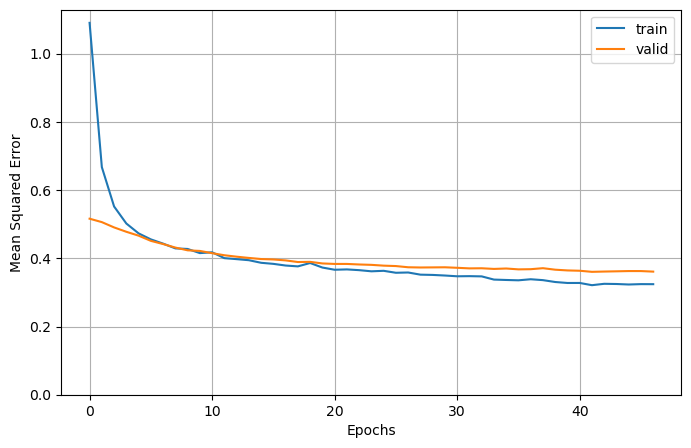

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


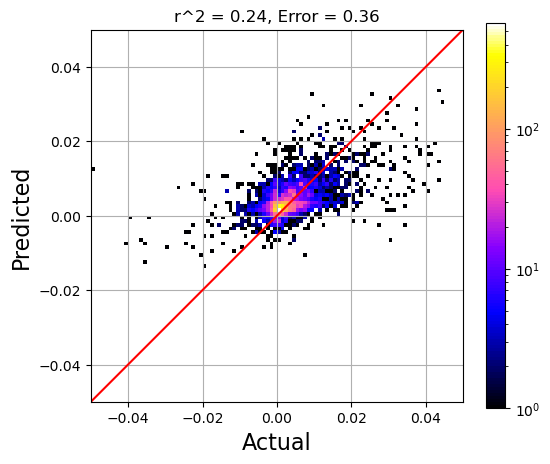

In [38]:
# Function to plot the training and validation loss at each epoch
def plot_loss(hist_obs):
    # Create Figure
    plt.figure(figsize=(8, 5))
    plt.plot(hist_obs.history['loss'], label='train')
    plt.plot(hist_obs.history['val_loss'], label='valid')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}eval_loss.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()

# Function to plot the actual vs predicted OPGs
def plot_act_pred(modelx, hist_obs):
    # Using our fitted model, predict OPGs from the testing subset.
    predicted = modelx.predict(test_atmos)

    # set zero OPGs to nan
    actual = test_opg
    actual[actual==0] = np.nan
    predicted[predicted==0] = np.nan
    
    # Convert from standardized OPG to mm/m OPG
    actual    = (test_opg * opg_sd) + opg_mean
    predicted = (predicted * opg_sd) + opg_mean
    
    # Since days without OPG observations are set to zero, lets reshape our OPGs and remove zero OPG days
    actual    = np.reshape(actual, -1)
    predicted = np.reshape(predicted, -1)
    idx       = np.isnan(actual) # Identify days without OPG observations
    actual    = actual[idx==False]
    predicted = predicted[idx==False]
    
    # Formulate the x and y axis limits
    max_val = np.max((np.max(predicted[:]), np.max(actual[:])))
    min_val = np.min((np.min(predicted[:]), np.min(actual[:])))
    max_val = 0.05
    min_val = -0.05
    
    # Define plot colormap
    cmap_gnuplot2 = ncm.cmap("MPL_gnuplot2")
    
    # Define label sizes
    label_size = 16
    tick_size = 14
    
    # Create Figure
    plt.figure(figsize=(6, 5))
    
    # Formulate the heatmap variables
    heatmap, xedges, yedges = np.histogram2d(np.reshape(actual, -1), np.reshape(predicted, -1), bins=100,
                                 range=[[min_val, max_val],[min_val, max_val]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap_gnuplot2, norm=colors.LogNorm())

    # Plot One-to-one line
    plt.plot([xedges[0], xedges[-1]], [yedges[0], yedges[-1]], c='red')
    
    # corr
    corr = np.round(np.corrcoef(actual, predicted)[0,1]**2 , 2)
    last_mse = np.round(hist_obs.history['val_loss'][-1], 2)
    
    # Add labels, gridlines, and colorbar
    plt.xlabel("Actual", fontsize=label_size)
    plt.ylabel("Predicted", fontsize=label_size)
    plt.title("r^2 = " + str(corr) + ", Error = " + str(last_mse))
    plt.grid(True)
    plt.colorbar()

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}eval_actual_vs_pred.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()


plot_loss(hist)
plot_act_pred(model, hist)

##### From the training and validation loss plot, we should see a smooth decrease in mean squared error until the `EarlyStopping` function ended training. 

##### The actual vs predicted OPG plot indicates some underpredicted of high OPGs and overprediction of low OPGs. Though as shown with the log-scale colormap, a significant majority of OPGs are near- or just above zero. With less examples of extreme OPGs to train from, extreme values are more difficult to predict. 

## Feature Maps - Convolutional, Max Pooling Layers, and Batch Normalization

##### Let's take a closer look at how the convolutional, max-pooling, and batch normalization process by visually by plotting feature maps. Here, we will index the same days from the CIROH_Datasets.ipynb script.

In [26]:
# List of dates to plot
dates = np.array(['2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12'], dtype='datetime64')

# Find index of these dates within the Xarray
idx = IVT.time.dt.date.isin(dates)

# Index Atmospheric Variables
atmos_subset = atmos_std[idx,...]

##### Below is the function that formulates feature maps from predictor data.

In [27]:
def feature_maps(layer_name, inputs):
    # Create a sudo-model that takes the input images and outputs 
    # the layer desired from the model already trained.
    feature_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output])

    # Then compute the gradient of the top predicted class for our
    # input image with resepct to the activations of the layer
    LAYER = feature_model.predict(inputs)

    # Standardize, then normalize the feature maps
    LAYER = (LAYER - np.mean(LAYER)) / np.std(LAYER)
    LAYER[LAYER < 0] = 0
    LAYER /= np.max(LAYER)

    return LAYER

##### Now lets loop through only 1 day of input data, call the feature_maps() function, and plot the layers. This function runs quite slow, but if you want to see more dates, uncomment `for dayx in range(np.shape(atmos_subset)[0]):`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


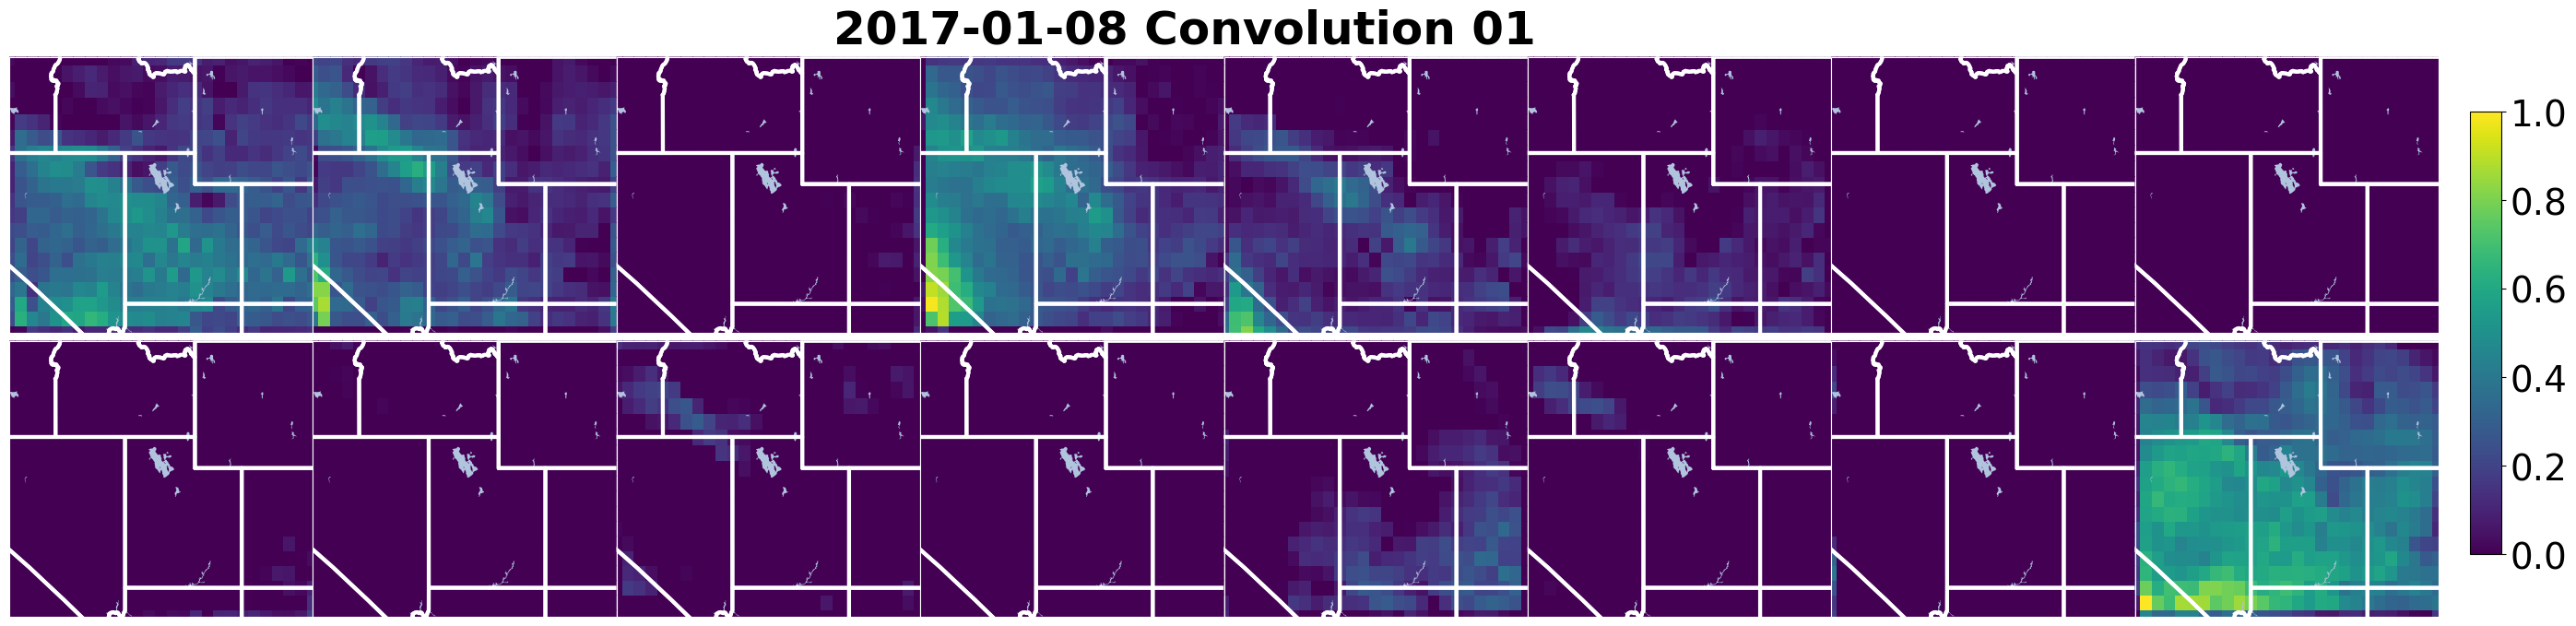

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


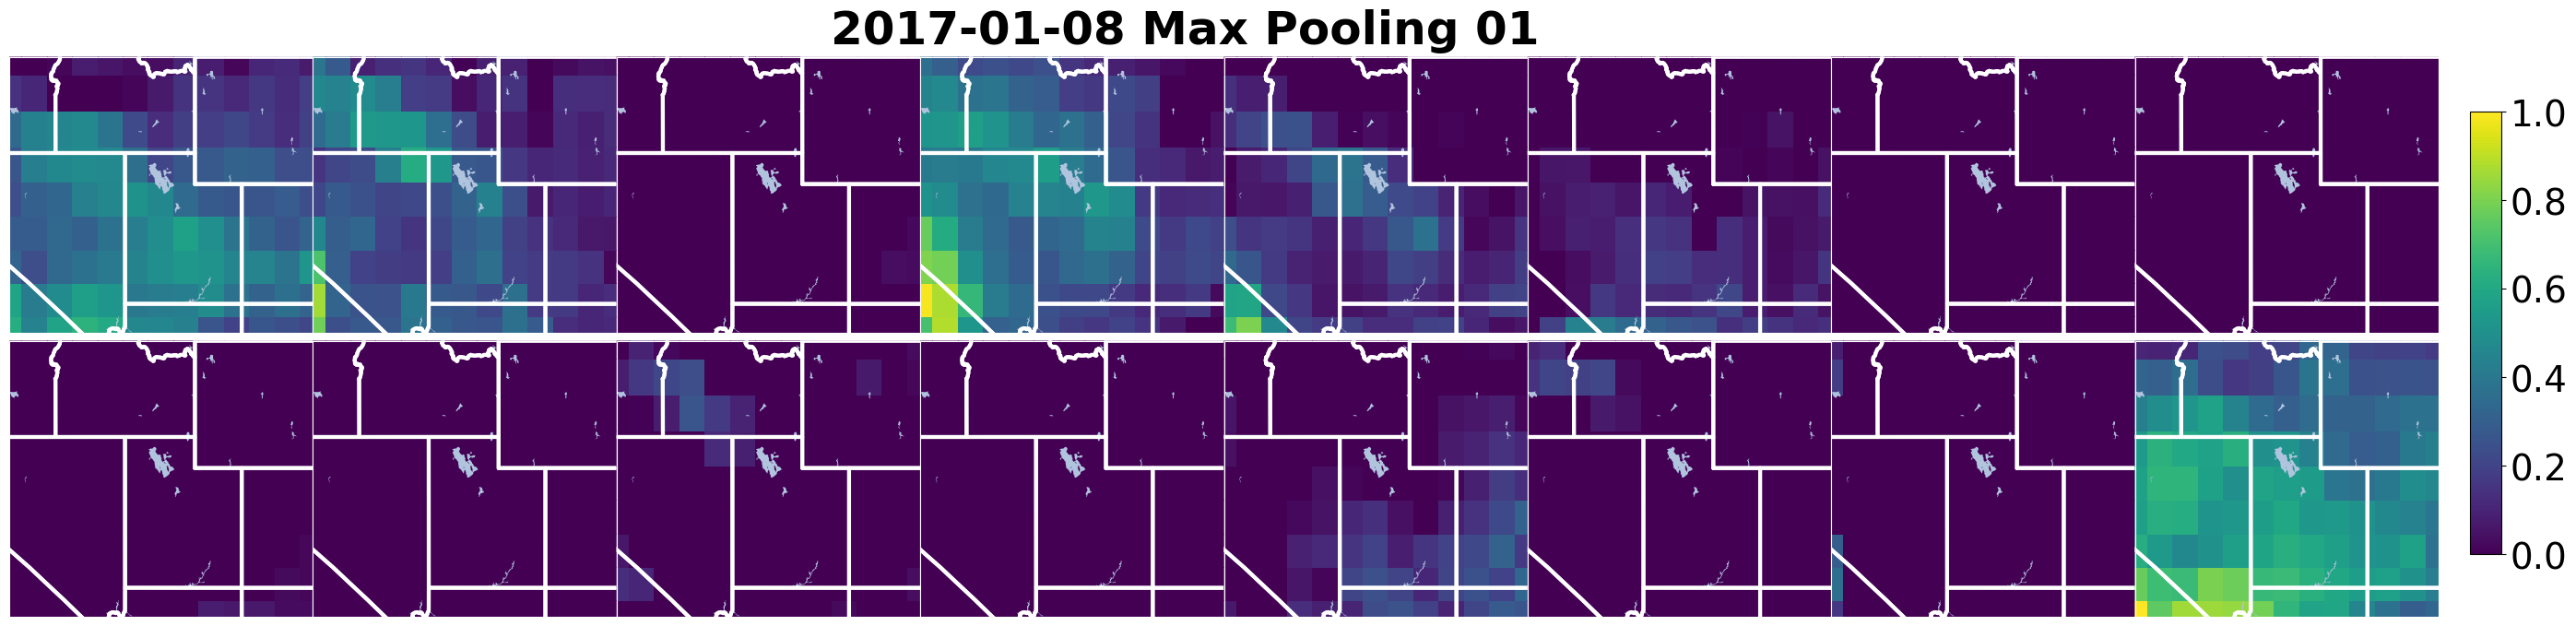

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


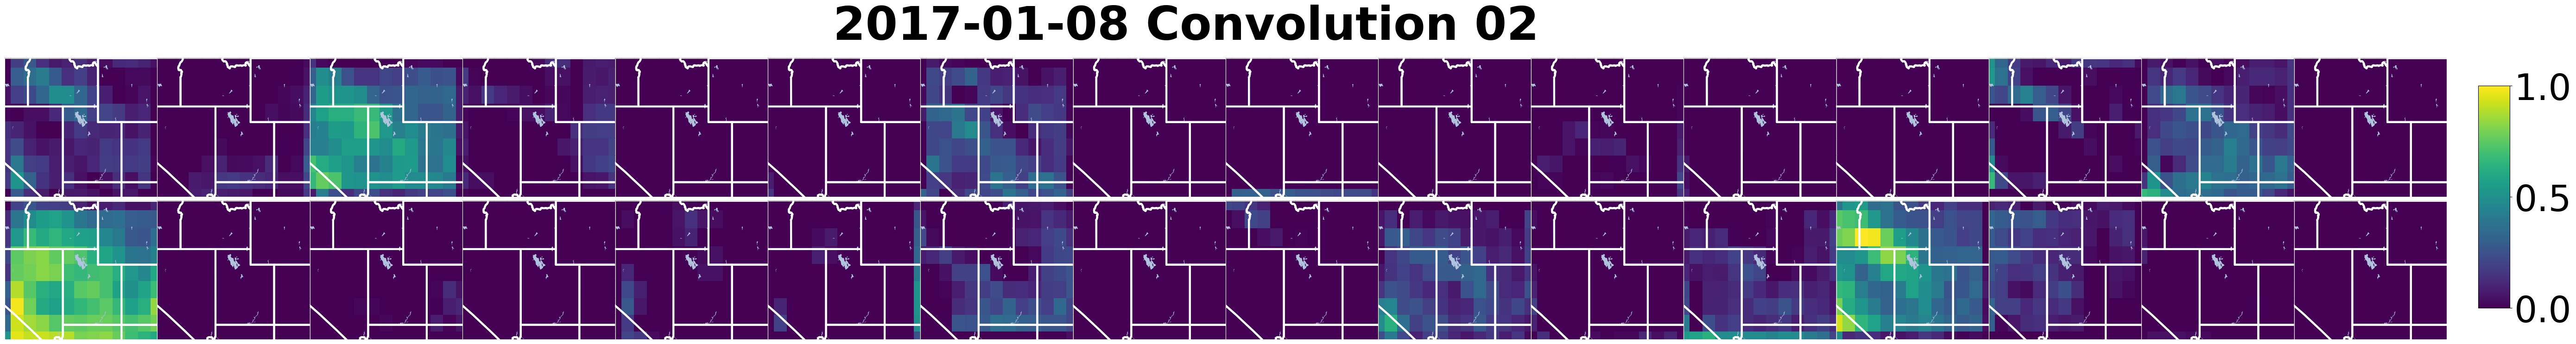

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


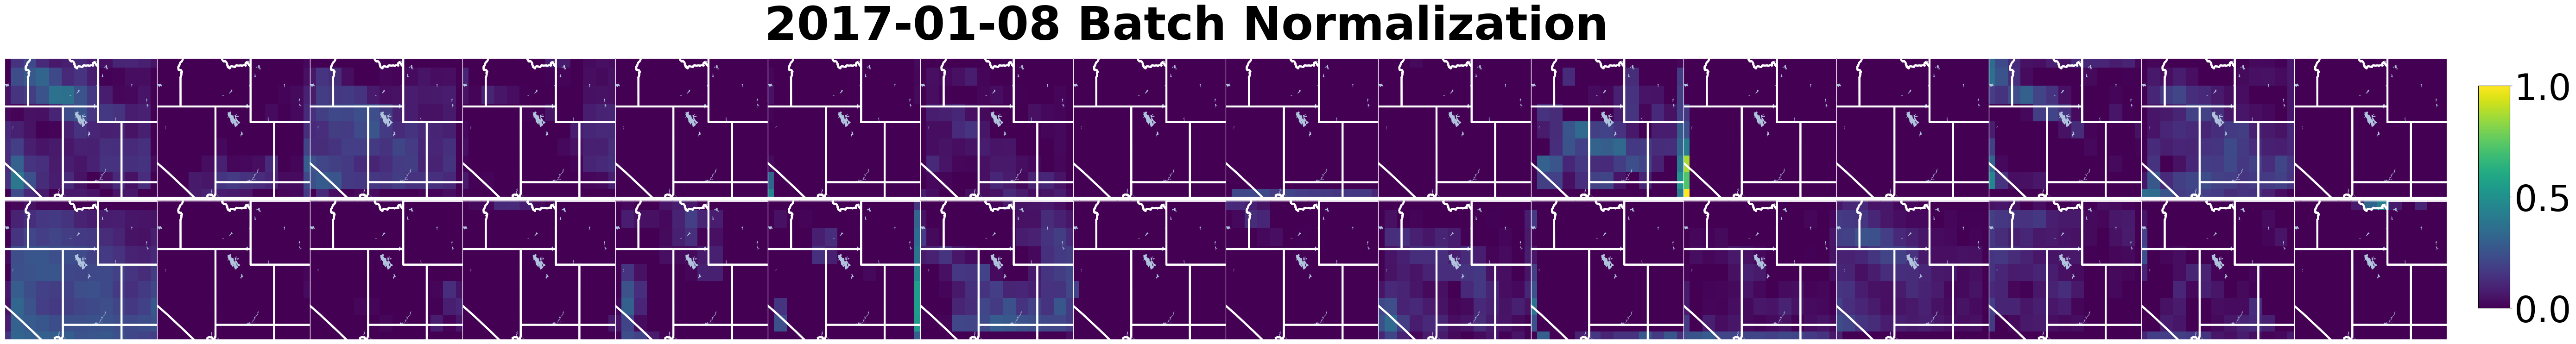

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


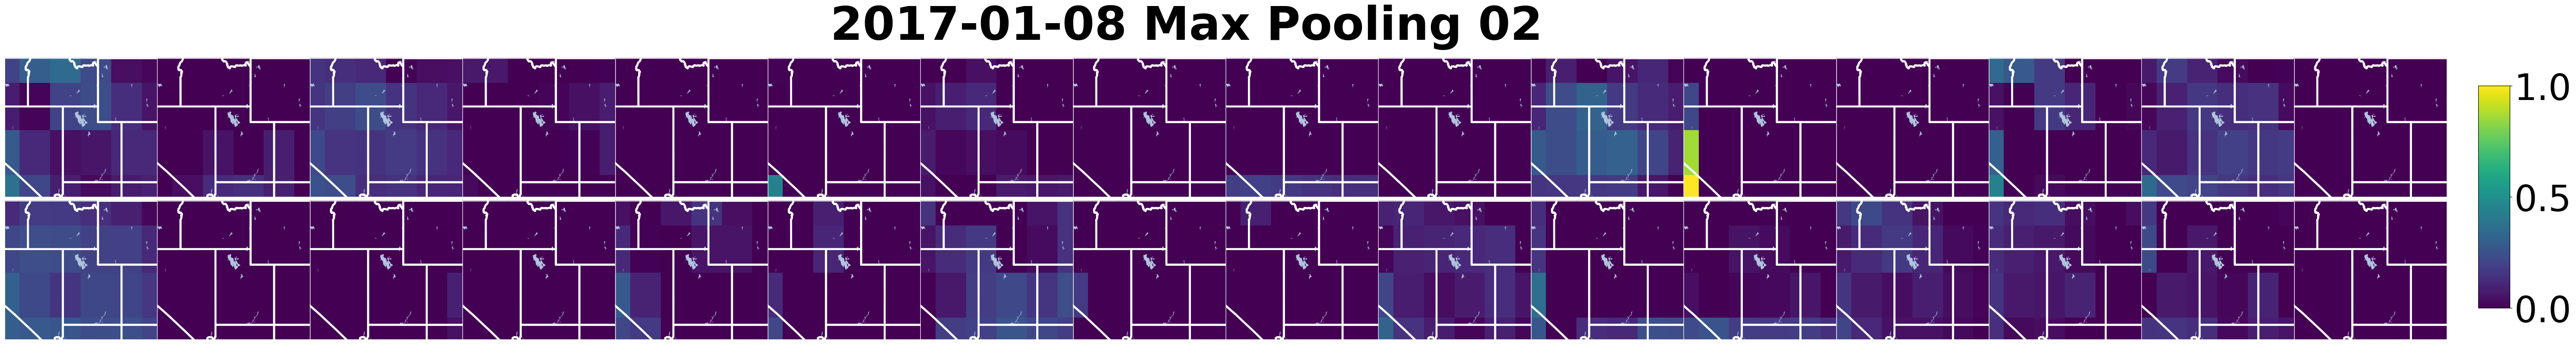

In [28]:
extent = [-119, -106, 36, 45] # set lat/lon extent of plots
datacrs = ccrs.PlateCarree()  # Map Projections

for dayx in range(1,2):                            # <-- Keep to loop through only 1 date
# for dayx in range(np.shape(atmos_subset)[0]):    # <-- Uncomment to see feature maps from all 6 dates
    # Index the atmospheric variables from looped day
    inputs = [atmos_subset[[dayx],:,:,:]]  

    # Pull date name
    datex = np.datetime_as_string(dates[dayx], unit="D")
    
    # Loop through each layer
    for lx in range(len(model.layers)):
        # Pull layer name from model
        layer = model.layers[lx] 
        
        if ('Conv' not in layer.name) and ('Max' not in layer.name) and ('Batch' not in layer.name):
           continue # skip if not convolutional, max pooling or batch normalization layer

        ########## FORMULATE FEATURE MAPS FROM THE PREDICTORS ##########
        LAYER = feature_maps(layer.name, inputs)

        ########## PLOT FEATURE MAPS ##########
        # Create mesh grid of lat/lons to plot the feature maps onto
        lats = np.linspace(np.min(lat_ERA5), np.max(lat_ERA5), num=np.shape(LAYER)[1], endpoint=True)
        lons = np.linspace(np.min(lon_ERA5), np.max(lon_ERA5), num=np.shape(LAYER)[2], endpoint=True)
        loni, lati = np.meshgrid(lons, lats)
    
        # Create the size of the figure and subplots
        y_axis = 2
        x_axis = np.ceil(np.shape(LAYER)[3]/y_axis).astype('int')
        
        # Plot projection
        projex = ccrs.Mercator(central_longitude=np.mean(lons))
    
        # Create figure and the sub-axes
        fig, ax = plt.subplots(nrows=y_axis, ncols=x_axis, figsize=(x_axis*4.25, y_axis*4),
                               subplot_kw={'projection': projex})
        
        ax_count = 0 # value to count the feature maps
        for row in range(y_axis):
            for col in range(x_axis):
                if ax_count < np.shape(LAYER)[3]:                    
                    # Plot Feature Map                    
                    feat_c = ax[row, col].pcolor(loni, lati, np.squeeze(LAYER[0, :, :, ax_count]), 
                                        clim=[0, 1], zorder=1, cmap='viridis', transform=datacrs)
                    
                    # Plot lakes, state boundaries, and set extent of maps
                    ax[row,col].add_feature(cfeat.LAKES.with_scale('10m'), facecolor="lightsteelblue", linewidth=3)
                    ax[row,col].add_feature(cfeat.STATES.with_scale('10m'), edgecolor="white", linewidth=3)
                    ax[row,col].set_extent(extent)

                    # Set edgecolor to white
                    for spine in ax[row,col].spines.values(): spine.set_edgecolor("white")

                    # Add to count variable
                    ax_count += 1

                # After we plot every feature map, extra axes are removed from plot
                elif ax_count >= np.shape(LAYER)[3]: ax[row, col].axis('off')

        # Pull layer name, then create title
        name = layer.name
        plt.suptitle(datex + " " + name.replace("_", " "), fontsize=4.5*x_axis, y=0.86+(x_axis/100), weight='bold')

        # Add colorbar
        cbar_feat = fig.add_axes([0.91, 0.2, 0.01, 0.6])
        cb_at = fig.colorbar(feat_c, cax=cbar_feat, #ticks=np.arange(-6,8,2),
                              pad=0.0, aspect=15, fraction=0.032)
        cb_at.ax.tick_params(labelsize=3.5*x_axis)

        # Tighten layout
        #plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)

        # Save and show figure
        path = "../figures/"
        plt.savefig(f"{path}feature_maps_{datex}_{name}.png", dpi=200, transparent=True,  bbox_inches='tight')
        plt.show()


##### Above are the feature maps for the convolutional, max-pooling, and batch normalization layers. Purple indicates the lowest values and yellow indicates the highest. Each type of layer are evaluated as:

- Convolutional: Regions of lighter colors indicate where the convolutional filters highlight, the patterns the CNN learned were important for OPG prediction.

- Max-Pooling: Shows how the max-pooling layer coarsens the images.

- Batch Normalization: This layer normalizes the current batch, which helps the CNN generalize the data. 

## Gradient-weighted Class Activation Maps (Grad-CAM)

##### Grad-CAMs identify the influential regions within an image associated with a CNN's prediction to aid in evaluating the CNN. Effectively, Grad-CAMs are heatmaps highlighting where the CNN focuses on within each input image during a prediction. These heatmaps are the formulated gradinets form the predicted value to a layer within the CNN, with stronger gradients indicating stronger influence. 

In [29]:
# List of dates to plot
dates = np.array(['2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12'], dtype='datetime64')

# Find index of these dates within the Xarray
idx = IVT.time.dt.date.isin(dates)

# Index standardized atmospheric variables for prediction
atmos_subset = atmos_std[idx,...]

# Index original atmospheric variables for plotting
IVT_subset       = IVT.sel(time=slice(dates[0], dates[-1]))
precip_subset    = precip.sel(time=slice(dates[0], dates[-1]))
temp700_subset   = temp700.sel(time=slice(dates[0], dates[-1]))
uwinds700_subset = uwinds700.sel(time=slice(dates[0], dates[-1]))
vwinds700_subset = vwinds700.sel(time=slice(dates[0], dates[-1]))
hgt500_subset    = hgt500.sel(time=slice(dates[0], dates[-1]))

##### Below is the function to formulate the Grad-CAMs from the predictor dataset. The steps of this function differ from others becasue it creates a composite of all output nodes. Most often, Grad-CAMs are formulated for CNNs predicting classifications, in which the output of individual nodes, like the target value, is most important.

In [30]:
def grad_cam(inputs):
    lastConvName  = 'Convolution_02'
    outputDenseName = 'Output'
    
    # Create a sudo-model that takes the input images and outputs 
    # the activation of the last convolutional layer as well as the predictions.
    gradCAM_model = tf.keras.models.Model(model.inputs, [model.get_layer(lastConvName).output, model.get_layer(outputDenseName).output])
    
    # Create empty list to hold activation maps
    heatmap = []
    
    for output_node in range(len(facet_list)):
    
        # Compute the activation maps from the output node to the input image with 
        # respect to the activations of the last convolutional layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = gradCAM_model(inputs)
            output_node_value = preds[:, output_node]
        
        # Formulate the gradient from the output value and the last convolutional layer's feature maps
        grads = tape.gradient(output_node_value, last_conv_layer_output)
    
        # Formulate the mean intensity of the gradients within each feature map
        # i.e., How important is each feature map?
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
        # Reduce axes of array because the array shape is: (1, 9, 13, 32)
        last_conv_layer_output = tf.squeeze(last_conv_layer_output)
    
        # Using matrix multiplication, multiply the importance of each 
        # activation map by the mean gradient on each activation map
        heatmap_output_node = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
        # Because we are formulating a Grad-CAM for ALL output nodes to then combine 
        # all Grad-CAMs into one plot, a novel process, we will save the heatmap to a list
        heatmap.append(np.array(heatmap_output_node))
    
    # With all the heatmaps saved from all output nodes, lets concatenate them into one array
    heatmap = np.concatenate(heatmap, axis=2)
    
    # Sift out the max activation from all activation maps
    heatmap = np.max(heatmap, axis=2)
    
    # Scale values to maximum of 1 and set all negative values to zero
    heatmap = heatmap / np.max(heatmap[:])
    heatmap[heatmap < 0] = 0

    return heatmap

##### Here, lets loop through each date, call the Grad-CAM function, and plot a composite Grad-CAM.

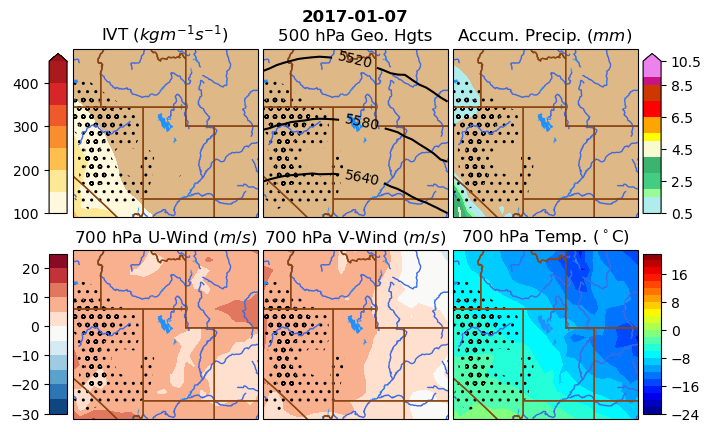

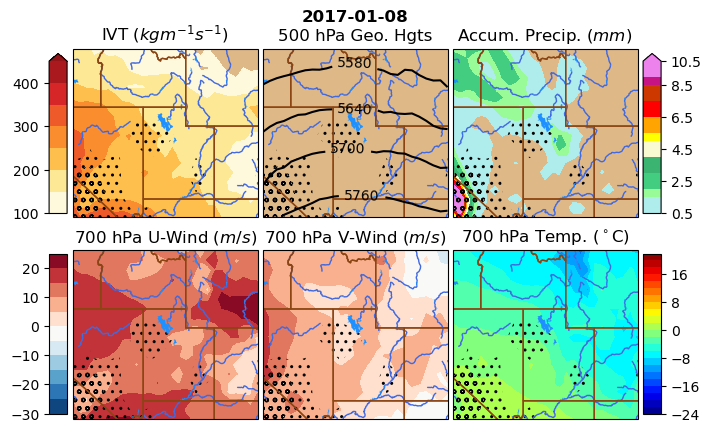

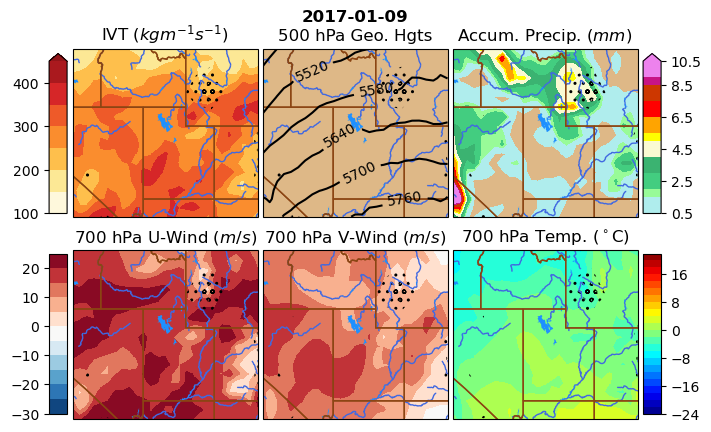

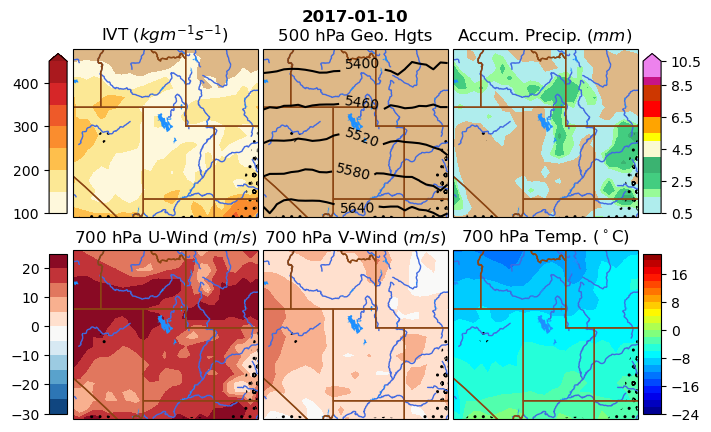

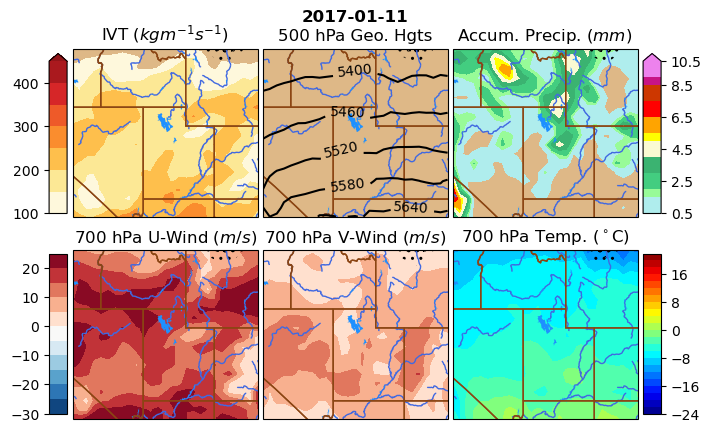

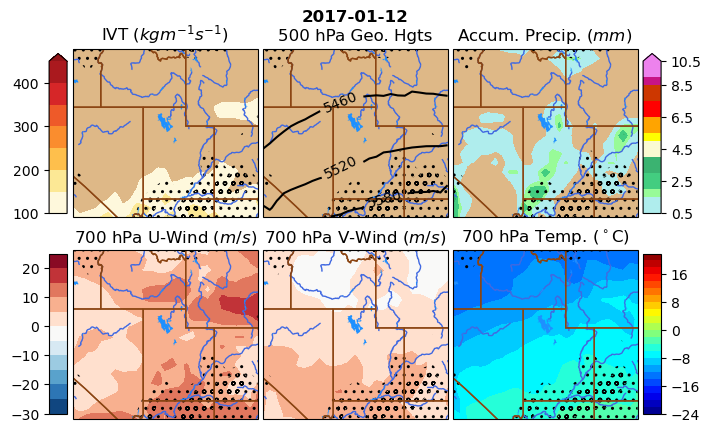

In [31]:
extent = [-119, -106, 36, 45] # set lat/lon extent of plots
datacrs = ccrs.PlateCarree()  # Map Projections

# Loop through each day
for dayx in range(np.shape(atmos_subset)[0]):
    # Index the atmospheric variables from looped day
    inputs = [atmos_subset[[dayx],:,:,:]]  

    # Pull date name
    datex = np.datetime_as_string(dates[dayx], unit="D")

    ########## FORMULATE GRAD-CAMS FOR ALL NODES ##########
    heatmap = grad_cam(inputs)

    ########## PLOT GRAD-CAM ONTOP OF ATMOSPHERIC VARIABLES ##########
    
    # Create mesh grid of lat/lons to plot the feature maps onto
    lats = np.linspace(np.min(lat_ERA5), np.max(lat_ERA5), num=np.shape(heatmap)[0], endpoint=True)
    lons = np.linspace(np.min(lon_ERA5), np.max(lon_ERA5), num=np.shape(heatmap)[1], endpoint=True)
    loni, lati = np.meshgrid(lons, lats)

    # Create figure
    fig, axs = plt.subplots(2, 3, figsize = (6, 4), subplot_kw={'projection': projex})
    fig.tight_layout()

    # Plot contourf and contour
    ivt_cbar = axs[0, 0].contourf(IVT_subset.longitude, IVT_subset.latitude, IVT_subset.IVT.values[dayx,:,:], 
                                  cmap=ncm.cmap('WhiteYellowOrangeRed'), levels=np.arange(100, 500, 50), 
                                  extend='max', transform=datacrs)
    cs       = axs[0, 1].contour(hgt500_subset.longitude, hgt500_subset.latitude, hgt500_subset.hgt.values[dayx,:,:], 
                                 colors='black', levels=np.arange(5160, 5880, 60), transform=datacrs)
    pr_cbar  = axs[0, 2].contourf(precip_subset.longitude, precip_subset.latitude, precip_subset.precip.values[dayx,:,:], 
                                  cmap=ncm.cmapDiscrete('prcp_2', indexList=np.arange(1,12)), 
                                  levels=np.arange(0.5, 10.5, 0.5), extend='max', transform=datacrs)
    u_cbar   = axs[1, 0].contourf(uwinds700_subset.longitude, uwinds700_subset.latitude, uwinds700_subset.uwnd.values[dayx,:,:], 
                                  cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30, 5), transform=datacrs)
    v_cbar   = axs[1, 1].contourf(vwinds700_subset.longitude, vwinds700_subset.latitude, vwinds700_subset.vwnd.values[dayx,:,:], 
                                  cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30, 5), transform=datacrs)
    tmp_cbar = axs[1, 2].contourf(temp700_subset.longitude, temp700_subset.latitude, temp700_subset.temp.values[dayx,:,:], 
                                  cmap=ncm.cmap('NCV_jet'), levels=np.arange(-24, 24, 2), transform=datacrs)

    # Set title
    axs[0, 0].set_title("IVT ($kg m^{-1} s^{-1}$)")  
    axs[0, 1].set_title("500 hPa Geo. Hgts")
    axs[0, 2].set_title("Accum. Precip. ($mm$)")
    axs[1, 0].set_title("700 hPa U-Wind ($m/s$)")
    axs[1, 1].set_title("700 hPa V-Wind ($m/s$)")
    axs[1, 2].set_title("700 hPa Temp. ($^\circ$C)")   

    # Plot 500 hPa geopotential height contour labels
    axs[0, 1].clabel(cs, fmt="%d", inline = True)

    # Add colorbars
    cx_ivt = fig.add_axes([-0.01, 0.55, 0.03, 0.40])
    fig.colorbar(ivt_cbar, cax=cx_ivt, ticks=np.arange(100, 500, 100), orientation='vertical', location='left')

    cx_u = fig.add_axes([-0.01, 0.05, 0.03, 0.40])
    fig.colorbar(u_cbar, cax=cx_u, ticks=np.arange(-30, 30+1, 10), orientation='vertical', location='left')

    cx_tmp = fig.add_axes([0.98, 0.05, 0.03, 0.40])
    fig.colorbar(tmp_cbar, cax=cx_tmp, ticks=np.arange(-24, 24, 8), orientation='vertical', location='right')

    cx_pr = fig.add_axes([0.98, 0.55, 0.03, 0.40])
    fig.colorbar(pr_cbar, cax=cx_pr, ticks=np.arange(0.5, 12, 2), orientation='vertical', location='right')

    # Add Grad-CAMs
    for row in range(2):
        for col in range(3):
            axs[row, col].contourf(loni, lati, heatmap, colors='none', transform=datacrs,
                                   hatches=[None, None, None, '..', 'oo'], levels=[0, 0.2, 0.4, 0.6, 0.8, 1.00])
    
    # Add wind barbs
    #u700 = uwinds700_subset.uwnd.values[dayx,::5,::5] * 1.94384  
    #v700 = vwinds700_subset.vwnd.values[dayx,::5,::5] * 1.94384
    #axs[1, 0].barbs(uwinds700_subset.longitude[::5], uwinds700_subset.latitude[::5], 
    #                u700, v700, length=6, pivot='middle', transform=datacrs)
    #axs[1, 1].barbs(uwinds700_subset.longitude[::5], uwinds700_subset.latitude[::5], 
    #                u700, v700, length=6, pivot='middle', transform=datacrs)
    
    # Add Cartogrphy
    for row in range(2):
        for col in range(3):
            axs[row,col].add_feature(cfeat.LAND, facecolor="burlywood")
            axs[row,col].add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="royalblue")
            axs[row,col].add_feature(cfeat.LAKES.with_scale('10m'), facecolor="dodgerblue")
            axs[row,col].add_feature(cfeat.STATES.with_scale('10m'), edgecolor="saddlebrown")
            axs[row,col].set_extent(extent)

    # adjust plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    datex = np.datetime_as_string(IVT_subset.time.values[dayx], unit="D")
    plt.suptitle(datex, y=1.06, weight='bold')

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}grad_cam_{datex}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()

##### The above plots show the composite Grad-CAMs for 6 dates. The stippling indicates where the CNN is looking to make a prediction, with the open circles indicating the most important regions.

##### Scrolling through the plots, it seems the CNN focuses on areas of high precipitation and high u-winds. 

##### Do you notice any patterns or values where the CNN focuses for prediction?

## Downscaling

##### The goal of our CNN is to predict Orographic precipitation gradients... but why? These orographic precipitation gradients can then be used to downscale precipitation over complex terrain. 

##### To make downscaling a quick process, lets depend on the strong correlation between the observed OPG and y-intercepts. This correlation tends to range between 0.6 and 0.95. First, we'll load in the linear relationships between the two variables, the topographic data, and the dates to downscale.

In [32]:
# Load in data
path = "../datasets/facets_and_opgs/"

# Load in the observed linear relationship between OPG and y-intercepts
corrOPGyint  = pd.read_csv(f"{path}winter_northernUT_lin_model_opg_y-int.csv", index_col=0)
facet_list   = np.asarray(corrOPGyint.columns.values, dtype=float)
variables    = corrOPGyint.index.values
coefs        = corrOPGyint.values

# Load in topographic data needed for downscaling
elev            = np.array(pd.read_csv(f"{path}elevation.csv", index_col=0))
facets          = np.array(pd.read_csv(f"{path}facet_labels.csv", index_col=0))
lats            = np.array(pd.read_csv(f"{path}lats.csv", index_col=0))
lons            = np.array(pd.read_csv(f"{path}lons.csv", index_col=0))
prcp_obs        = np.array(pd.read_csv(f"{path}winter_northernUT_precip_obs.csv", index_col=0))
prcp_obs_latlon = np.array(pd.read_csv(f"{path}winter_northernUT_precip_obs_latlon.csv", index_col=0))

# List of dates to plot
dates = np.array(['2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12'], dtype='datetime64')

# Find index of these dates within the Xarray
idx = IVT.time.dt.date.isin(dates)

# Index ERA5 precip variables
precip_subset = precip.sel(time=slice(dates[0], dates[-1]))

# Subset the observational dates from the mesonet
prcp_obs_subset = prcp_obs[idx, :]

##### Next lets predict OPGs over the same days we have been working with, and convert the standardized values to the actual values.

In [33]:
# Predict atmos subset
pred_opg = model.predict(atmos_subset)

# set zero OPGs to nan
pred_opg[pred_opg==0] = np.nan

# Convert from standardized OPG to mm/m OPG
pred_opg = (pred_opg * opg_sd) + opg_mean

print(np.shape(pred_opg))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(6, 30)


##### Now, we'll use the correlation between OPGs and the y-intercept to formulate the predicted y-intercepts.

In [34]:
# Create array to hold y-intercepts
pred_yint = np.zeros(np.shape(pred_opg))

# loop through each facet
for fi in range(np.shape(pred_opg)[1]):
    # Using the fit linear relationship, calculate the y-intercepts
    pred_yint[:, fi] = coefs[0, fi]*pred_opg[:, fi] + coefs[1, fi]

##### Here, we downscale precipitation to each facet using the predicted OPGs.

In [35]:
# Create array for the precipitation
opg_precip = np.zeros((np.shape(dates)[0], np.shape(elev)[0], np.shape(elev)[1]))

# Loop through each facet
for fi in range(np.shape(pred_opg)[1]):
    # loop through each day
    for dayx in range(np.shape(pred_opg)[0]):
        # Formulate precipitation total based on elevation of a facet, OPG, and y-intercept
        fi_precip = np.squeeze(([facets==facet_list[fi]])*(elev)*(pred_opg[dayx, fi]) + pred_yint[dayx, fi])

        # Save precipitation to opg_precip array
        opg_precip[dayx, facets==facet_list[fi]] = fi_precip[facets==facet_list[fi]]

# Set all negative values to zero, and all non-facets to NaNs
opg_precip[opg_precip < 0] = 0
opg_precip[:, np.isnan(facets)] = np.nan

##### Last, let's plot the ERA5 accumulated precipitation, observed precipitation from mesonet stations, and the CNN downscaled precipitation using OPGs

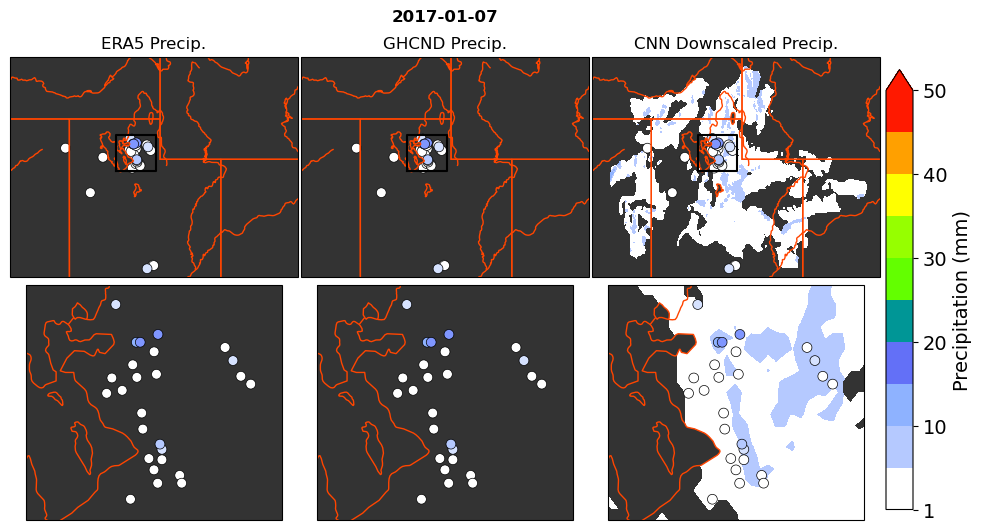

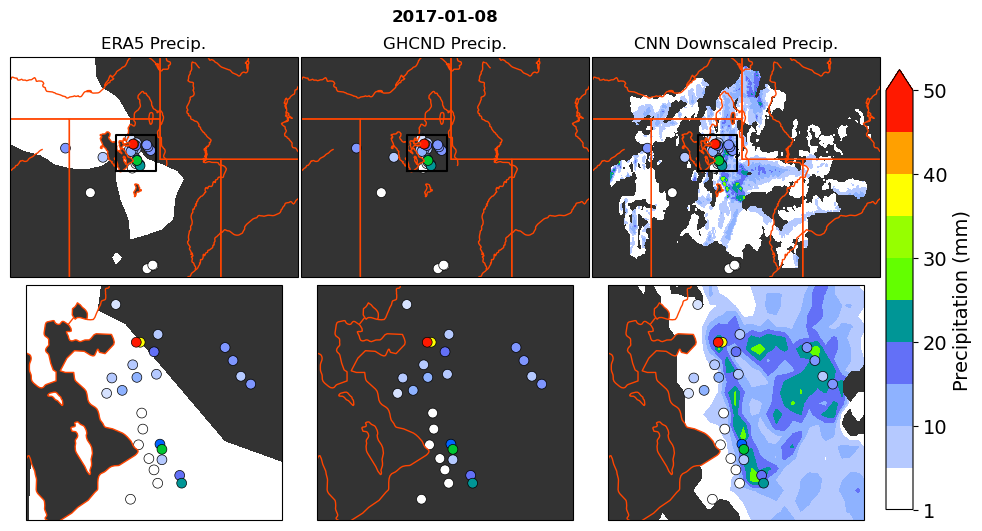

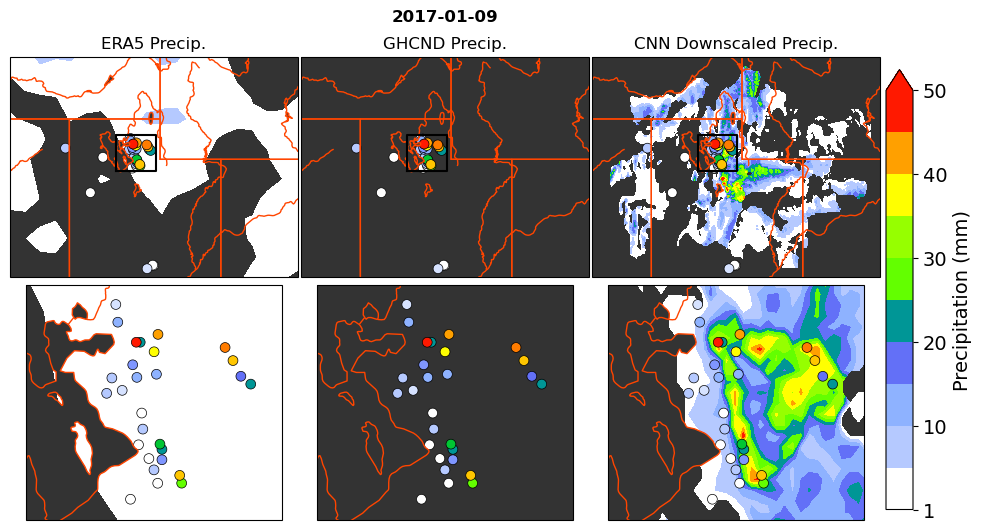

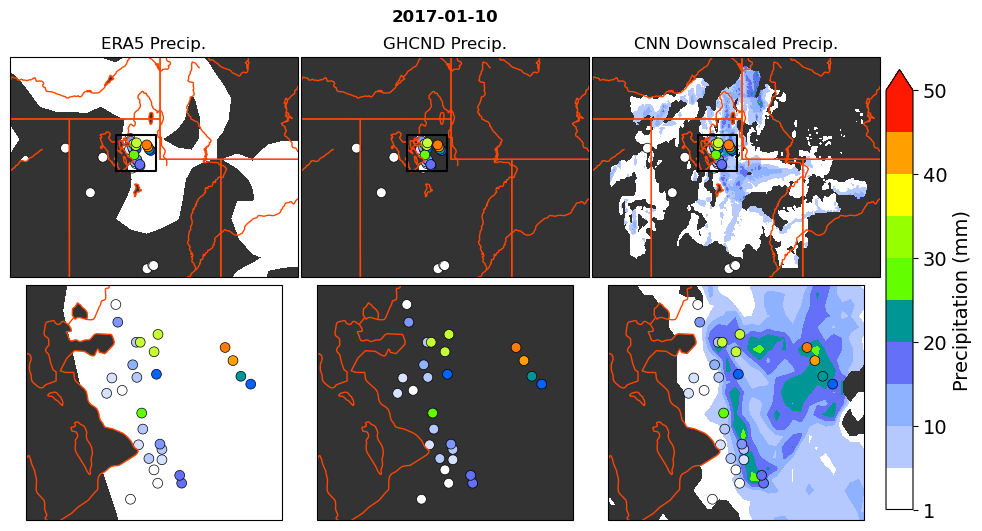

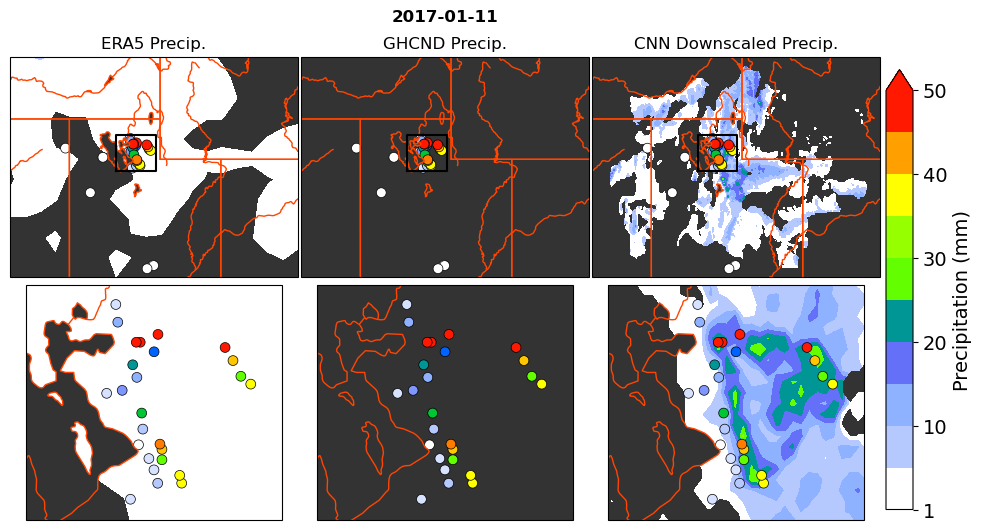

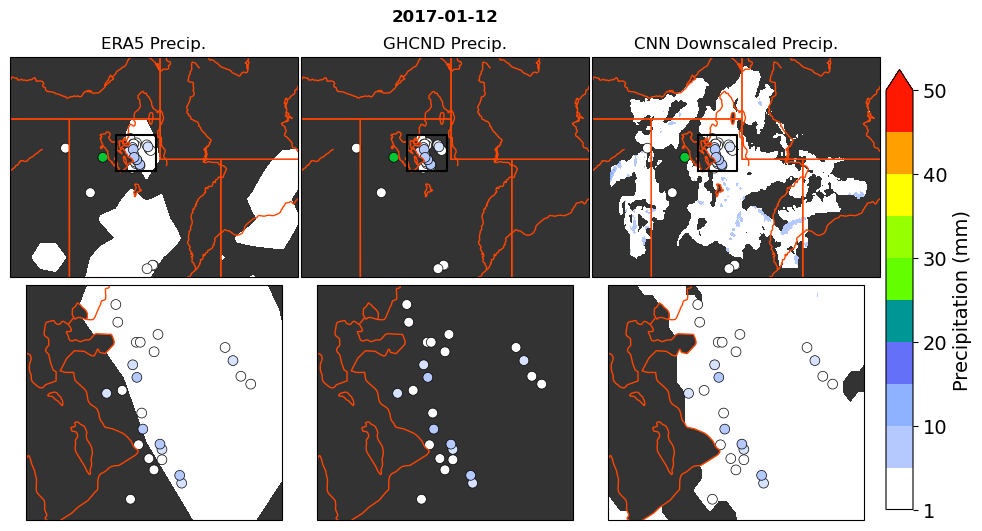

In [36]:
# Plot
extent1 = [-116, -106.5, 38, 43.5] # extent of plotting window in lons then lats
extent2 = [-112.5, -111.2, 40.7, 41.6] # extent of plotting window in lons then lats

levs    = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]#np.arange(0.1, 50, 5)
pr_cmap = ncm.cmapDiscrete('prcp_2', indexList=np.arange(1,12))
pr_cmap = ncm.cmap('precip3_16lev')

# Define plot type args
contourf_args = {'cmap': pr_cmap, 'levels': levs, 'extend': 'max', 'transform': datacrs}
scatter_args  = {'s': 50, 'vmin': levs[0], 'vmax': levs[-1], 'cmap': pr_cmap, 'edgecolor': 'black', 'linewidths': 0.5, 'transform': datacrs}
plot_args     = {'color': 'black', 'transform': datacrs}


for dayx in range(np.shape(pred_opg)[0]):

    # remove scatter points that are NaN
    idxNaN           = ~np.isnan(prcp_obs_subset[dayx, :])
    prcp_obs_subsetx = prcp_obs_subset[dayx, idxNaN]
    prcp_obs_latlonx = prcp_obs_latlon[idxNaN, :]

    # sort the precipitation data so that the highest observation is ontop
    idxSort = np.argsort(prcp_obs_subsetx)
    prcp_obs_subsetx = prcp_obs_subsetx[idxSort]
    prcp_obs_latlonx = prcp_obs_latlonx[idxSort, :]

    ########## PLOT PRECIPITATION FROM ERA5, GHCND, AND CNN DOWNSCALED ##########
    
    # Create figure
    fig, axs = plt.subplots(2, 3, figsize = (9, 5), subplot_kw={'projection': projex})
    fig.tight_layout()
    
    # Plot ERA5
    axs[0, 0].contourf(precip_subset.longitude, precip_subset.latitude, precip_subset.precip.values[dayx,:,:], **contourf_args)
    axs[0, 0].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[0, 0].plot([extent2[0], extent2[1], extent2[1], extent2[0], extent2[0]], 
                   [extent2[2], extent2[2], extent2[3], extent2[3], extent2[2]], **plot_args)
    axs[0, 0].set_title("ERA5 Precip.")
    axs[0, 0].set_extent(extent1)
    
    # Plot Observations
    axs[0, 1].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[0, 1].plot([extent2[0], extent2[1], extent2[1], extent2[0], extent2[0]],
                   [extent2[2], extent2[2], extent2[3], extent2[3], extent2[2]], **plot_args)
    axs[0, 1].set_title("GHCND Precip.")
    axs[0, 1].set_extent(extent1)
    
    # Plot Downscaled
    axs[0, 2].contourf(lons, lats, np.squeeze(opg_precip[dayx,:,:]), **contourf_args)
    axs[0, 2].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[0, 2].plot([extent2[0], extent2[1], extent2[1], extent2[0], extent2[0]],
                   [extent2[2], extent2[2], extent2[3], extent2[3], extent2[2]], **plot_args)
    axs[0, 2].set_title("CNN Downscaled Precip.")
    axs[0, 2].set_extent(extent1)

    # Plot ERA5
    axs[1, 0].contourf(precip_subset.longitude, precip_subset.latitude, precip_subset.precip.values[dayx,:,:], **contourf_args)
    axs[1, 0].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[1, 0].set_extent(extent2)
    
    # Plot Observations
    axs[1, 1].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[1, 1].set_extent(extent2)
    
    # Plot Downscaled
    pr = axs[1, 2].contourf(lons, lats, np.squeeze(opg_precip[dayx,:,:]), **contourf_args)
    axs[1, 2].scatter(prcp_obs_latlonx[:, 1], prcp_obs_latlonx[:, 0], c=prcp_obs_subsetx, **scatter_args)
    axs[1, 2].set_extent(extent2)
    
    # Add Cartogrphy
    for row in range(2):
        for col in range(3):
            axs[row,col].add_feature(cfeat.LAND, facecolor=[0.2, 0.2, 0.2])
            axs[row,col].add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="orangered")
            axs[row,col].add_feature(cfeat.LAKES.with_scale('10m'), edgecolor="orangered", facecolor=[0.2, 0.2, 0.2])
            axs[row,col].add_feature(cfeat.STATES.with_scale('10m'), edgecolor="orangered")

    # Add colorbar
    cbar_pr = fig.add_axes([0.99, 0.05, 0.03, 0.88])
    cb_at = fig.colorbar(pr, cax=cbar_pr, pad=0.0, aspect=15, fraction=0.032)
    cb_at.set_label('Precipitation (mm)', size=14)
    cb_at.ax.tick_params(labelsize=14)
    
    # adjust plot
    plt.subplots_adjust(wspace=0.01, hspace=0)
    datex = np.datetime_as_string(dates[dayx], unit="D")
    plt.suptitle(datex, y=1.05, weight='bold')
    
    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}downscaling_{datex}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()


##### Above are the comparisons between the ERA5 at 0.5 degree, GHCND observed precipitation, and the precipitation downscaled from the CNN's predicted OPGs.

